## House Price II: Modeling

### Charlie Huang

***

This is the second module of my study on the popular Kaggle project: *House Prices - Advanced Regression Techniques*. The first module focused on explorative data analysis using numpy/pandas and data visualization using matplotlib/seaborn. This module focuses on training machine learning models and optimizing model predictions on the separate test set.

After many hours of experimentation I pushed the leaderboard rank from 50% to top 20% with more careful data engineering and better models. I also found that **one single outlier in the test data is responsible for a 0.01 difference in the leaderboard score** (see the end of the notebook for more details). Taking care of this outlier alone would move my rank up to top 4%. However, I don't take this improvements as genuine since my models are not capable of figuring this out by themselves.

There are two metrics to evaluate a model:
1. Cross-validation score, e.g., kFolds, from the training data only
2. The leaderboard score.
As mentioned earlier, the leaderboard score may fluctuate drastically due to a single outlier and this is hard to control. Therefore, both metrics would be considered in evaluating the goodness of a model.

Here is a summary of data engineering procedures that may or may not affect the final score:
- **Outliers**
  
  I found that having slightly different criteria for outliers leads to large fluctuations (up to 0.01 in my experiments) in the final score. Removing more outliers often results in much better cross-validation scores using only the training data, but seems to only harm the submission score. Therefore I only threw out 2 outliers, which already improves the final score by 0.004.


- Transform **skewed features**  
  
  A clear improvement on both the cross-validation and the test set. Using boxcox1p is slightly better than log1p.


- **Feature engineering**
  - Add new features, e.g, totalSF, House age, log/poly features, etc.  

- **Missing values**
  - numerical: mean, median, 0
  - categorical: 0, most_frequent, 'none'

- **Feature encoding and scaling**
  - Numerical features: StandardScaler, RobustScaler
  - Ordinal features: OneHot, ordinal encoder
  - Target encoding for some nominal features, e.g., 'Neighborhood'

  I didn't find any of these choices leads to a significant improvement in the final score. The strongest predictors such as OverallQual, GrLivArea, ... are numerical and have no/little missing values. 


- **Hyperparameter tuning**

  Important for linear regressors. Did not help that much for XGBoost within a reason range.


- **Stacking** multiple regressors

  Quite helpful. A stacked regressor with both linear and tree-based models improves model predictions on both the cross-validation sets and also the test set. The model fitting is much slower. Using the default RidgeCV regressor as the primary model seems to work pretty well, though not significantly better than other choices like XGBoost. 


- **Blend** the results and final corrections on the predicted value 

  Blending results from different regressors leads to some improvements in the leaderboard score, but this is likely an artifact from the outlier: my experiments seem to show that a tree-based model, e.g., random forest regressor, predicts a lower value for the outlier, which is actually closer to the true value. So even though the RF performs less well on the cross-validation sets, blending it in will help with the leaderboard score. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, skew
from scipy.special import boxcox1p, inv_boxcox1p

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ShuffleSplit, learning_curve, cross_val_score, KFold
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from category_encoders.target_encoder import TargetEncoder

from sklearn import metrics
import json

Utility function: display a formatted list of parameters from the estimator of a pipeline.

In [2]:
def display_estimator_parameters_for_pipeline(ppl):
    '''
    Display a formatted list of all the parameters and their values of the estimator of a pipeline.

    Parameters:
    ---
    ppl: The pipeline of interest. The estimator must be the last step in the pipeline.
    '''
    name_model = ppl.steps[-1][0] + "__"
    print("Name: %s" % (ppl.steps[-1][0]))
    print("Estimator: %s" % (ppl.steps[-1][1]))    
    print("------------------------------------------------")
    pars = ppl.get_params()
    modelpars = {x: pars[x] for x in pars if name_model in x}
    for (key, val) in modelpars.items():
        print("%-24s: %-20s" % (key.replace(name_model, ""), str(val)))

In [ ]:
def examine_learning_curve(ppl, X, y, n_splits=5, modelname=""):
    '''
    Display the learning curves for a pipeline. The top panel shows the training errors and cross-validation errors as a function of the training sizes (subsample of 10% to 80% of the data). The bottom panel shows the time cost.

    Parameters:
    ---
    ppl: Pipeline or model. 
    X: Features of the training data
    y: Targets of the training data
    n_splits: Number of train/cross-validation pairs to resample
    '''

    fig, axs = plt.subplots(1, 2, num='learning_curve', figsize=(10,5))
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=12)
    lc_sizes, lc_train, lc_cv, lc_time, _ = \
        learning_curve(ppl, X, y, cv=cv, return_times=True, \
                       train_sizes=np.linspace(0.1, 1.0, 9),
                       scoring = 'neg_root_mean_squared_error')
    # score vs. size
    ax = axs.flatten()[0]
    x, y, dy = lc_sizes, lc_train.mean(axis=1), lc_train.std(axis=1)
    ax.plot(x, y, "bo-", label="training")
    ax.fill_between(x, y-dy, y+dy, alpha=0.2, color='blue')
    x, y, dy = lc_sizes, lc_cv.mean(axis=1), lc_cv.std(axis=1)
    ax.plot(x, y, "ro-", label="cross-validation")
    ax.fill_between(x, y-dy, y+dy, alpha=0.2, color='red')
    ax.legend(loc="lower right")
    ax.set_ylabel("RMSE")
    #ax.set_title("Learning Curve (%s)" % (ppl.steps[-1][0]))
    ax.set_title("Learning Curve (%s)" % (modelname))
    ax.grid()
    # time vs. size
    ax = axs.flatten()[1]
    x, y, dy = lc_sizes, lc_time.mean(axis=1), lc_time.std(axis=1)
    ax.plot(x, y, "bo-", label="Time")
    ax.set_ylabel("Time cost (sec)")
    ax.set_xlabel("Training Size")
    ax.legend(loc="lower right")
    ax.grid()
    plt.show()


In [79]:
print("Loading data from train.csv.")
train = pd.read_csv("./data/train.csv")
m = train.shape[0]

# outliers = train[train['GrLivArea'] > 4000].index
# outliers.union(train[train['GarageArea'] > 1200].index)
outliers = train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index

train = train.drop(outliers)

Loading data from train.csv.


## Feature Engineering

Same process should be applied to both the training and the test data, but separately.

Here is a summary of the pre-processing steps:
1. Perform log(1+x) transformation on the target, boxcox1p on other skewed features.
2. Drop several features from both the training and test set
  - 'Id': non-informative
  - 'Utilities', 'Street': single-valued
  - 'PoolQC', 'Alley', 'Fence', 'MiscFeature': Very sparse with more than 80% data missing.
3. Several features, e.g., 'MSSubClass', is falsely interpreted as numerical. Treat it as categorical.
4. Hard encode all ordinal features using input from a separate .json file.
5. Encodes several nominal features, e.g., 'Neighborhood', by ranking the categories according the median target values.
6. Fill missing values with 0 for some features (mostly area measures)
7. Transform other numerical features with a median imputer and a robust scaler
8. Transform other categorical features with OneHot Encoder ignoring missing values.

Details can be found in the first part of the notebook:

https://www.kaggle.com/shuiyaohuang/house-price-i-comprehensive-eda

In [80]:
def preprocessing(raw, rank_mapping=None):
    processed = raw.copy()

    # Drop features that will not be used in modeling
    # Combines features that would be dropped:
    drop_features = ["Id","Utilities","Street"]
    drop_features += ['Alley', 'PoolQC', 'Fence', 'MiscFeature'] # sparse features
    #drop_features += ['MoSold', 'YrSold', 'SaleType', 'SaleCondition']

    for var in drop_features:
        if(var in processed):
            # print("Drop feature: ", var)
            processed = processed.drop(var, axis=1)

    #Hard code the ordinal features using a .json file
    with open('./python/ordinal.json',) as f:
        ordinal_feature_encoder = json.load(f)
    processed = processed.replace(ordinal_feature_encoder)
    ord_features = pd.Index(ordinal_feature_encoder.keys()).join(processed.columns, how='inner')

    # MSSubClass is a nominal (categorical) feature but is encoded with numerics
    for col in ['MSSubClass', 'MoSold', 'SaleType', 'SaleCondition']:
        processed[col] = processed[col].astype('object')

    vars_fill_zero = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars']

    for var in vars_fill_zero:
        processed[var] = processed[var].fillna(0)
    for var in ord_features:
        processed[var] = processed[var].fillna(0)
        
    # Target encoding using ranked median 
    # Be aware of encoding the test set this way.
    if(rank_mapping is None):
        rank_mapping = dict()
        vars_te = ['Neighborhood', 'MSSubClass', 'Exterior1st', 'Exterior2nd', 'Condition1', 'SaleType', 'Condition2', 'RoofMatl']
        for var in vars_te:
            sorted_idx = processed.groupby(var)['SalePrice'].median().sort_values().argsort()
            processed[var] = processed[var].map(sorted_idx)
            rank_mapping[var] = sorted_idx
    else: # test set
        for var, sorted_idx in rank_mapping.items():
            processed[var] = processed[var].map(sorted_idx)
    
    #processed['TotalSF'] = processed['TotalBsmtSF'] + processed['1stFlrSF'] + processed['2ndFlrSF']

    num_features = processed.select_dtypes(['int', 'float']).columns
    vars_skewed = []
    #Apply boxcox transformation to all skewed features
    print("Skewness of variables: ")
    print("----------------")    
    for col in num_features:
        if(col == 'SalePrice'): continue
        if(abs(skew(processed[col])) > 1.0):
            vars_skewed.append(col)
            print("%-24s %f" % (col, skew(processed[col])))
            processed[col] = boxcox1p(processed[col], 0.15)
    if 'SalePrice' in processed.columns:
        processed['SalePrice'] = np.log1p(processed['SalePrice'])
    

    return processed, rank_mapping

In [81]:
train_derived, rank_mapping = preprocessing(train)

# Check whether or not the rank encoding is correct
# train_derived.groupby('Neighborhood')['SalePrice'].median()

Skewness of variables: 
----------------
LotArea                  12.560986
Condition2               -8.738067
RoofMatl                 10.313383
MasVnrArea               2.693554
ExterCond                1.394028
BsmtQual                 -2.111877
BsmtCond                 -4.499602
BsmtFinType2             2.590165
BsmtFinSF2               4.247550
CentralAir               -3.523786
LowQualFinSF             8.995688
GrLivArea                1.009951
BsmtHalfBath             4.095895
KitchenAbvGr             4.480268
GarageQual               -3.480307
GarageCond               -3.534711
PavedDrive               3.302685
WoodDeckSF               1.544214
OpenPorchSF              2.337421
EnclosedPorch            3.083987
3SsnPorch                10.286510
ScreenPorch              4.114690
PoolArea                 15.932532
MiscVal                  24.434913
SaleType                 -1.131861


In [132]:
# Use pipelines for the rest of the features.

X = train_derived.drop('SalePrice', axis=1)
ytrain = train_derived['SalePrice']

num_features = X.select_dtypes(['int', 'float']).columns
cat_features = X.select_dtypes(['object']).columns

ppl_num = Pipeline(steps = \
    [('imp_num', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler())])    
# or StandardScaler
ppl_cat = Pipeline(steps = \
    [('imp_cat', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])
ct = ColumnTransformer(transformers= \
    [('numeric', ppl_num, num_features), \
     ('categorical', ppl_cat, cat_features)] \
)

ct.fit(X)
Xtrain = ct.transform(X)

## Tuning Hyperparameters
### Example: Lasso

I used a list of 6 independent models for fitting the data. I didn't extensively tune the parameters so the tuning process is omitted here. Nevertheless, here is an example for tuning the Lasso regressor: 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   12.0s finished


             mean_fit_time  mean_train_score  mean_test_score
param_alpha                                                  
0.000100          0.230904         -0.098744        -0.114259
0.000118          0.257198         -0.098913        -0.114050
0.000137          0.208247         -0.099090        -0.113864
0.000155          0.219001         -0.099262        -0.113722
0.000173          0.262790         -0.099433        -0.113559
0.000192          0.156886         -0.099606        -0.113407
0.000210          0.142034         -0.099762        -0.113252
0.000229          0.144700         -0.099918        -0.113104
0.000247          0.120826         -0.100078        -0.112969
0.000265          0.187293         -0.100243        -0.112842
0.000284          0.232261         -0.100412        -0.112734
0.000302          0.192153         -0.100588        -0.112634
0.000320          0.147874         -0.100761        -0.112542
0.000339          0.222148         -0.100923        -0.112459
0.000357

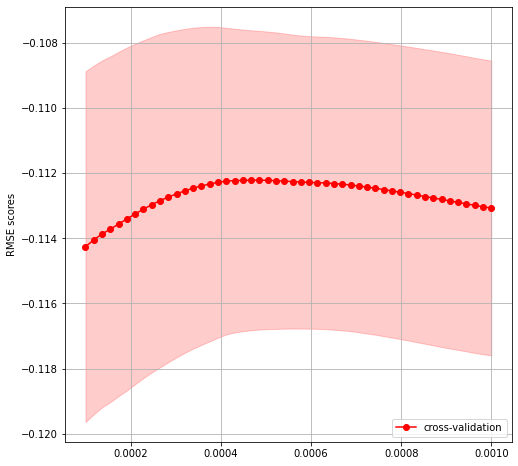

In [108]:
def train_model_lasso_parameters_search(X_train, y_train):
    model_lasso = Lasso(max_iter=100000)
    #grid_params = {'alpha':[1.e-5, 3.e-5, 0.0001, 0.0003, 0.001, 0.003, 0.1, 0.3]}
    grid_params = {'alpha':np.linspace(0.0001, 0.001, 50)}
    reg_lasso = GridSearchCV(model_lasso, grid_params, 
                             cv=5, verbose=3, n_jobs=-1, 
                             scoring = 'neg_root_mean_squared_error',
                             return_train_score=True) # r2
    model = reg_lasso.fit(X_train, y_train)
    gcv_matrix = pd.DataFrame(model.cv_results_)
    gcv_bestpar = model.best_params_
    gcv_scores = gcv_matrix.groupby('param_alpha')[['mean_test_score', 'std_test_score']].mean()
    print(gcv_matrix.groupby('param_alpha')[['mean_fit_time', 'mean_train_score', 'mean_test_score']].mean())
    print()        
    print("Best Parameters:")
    print("--------------------------------")
    for (key, val) in gcv_bestpar.items():
        print("%-24s: %-20s" % (key, str(val)))
    print()
    print("Best Fit Coefficients:")
    print("--------------------------------")
    #reg = reg_lasso.best_estimator_.named_steps['lasso']
    reg = reg_lasso.best_estimator_
    print("Mean: %f" % (abs(reg.coef_).mean()))
    print("Std : %f" % (abs(reg.coef_).std()))
    print()
    #print("Best Score (Hold-out): %7.5f" % (reg_lasso.score(X_test, y_test)))
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    x, y, dy = gcv_scores.index, gcv_scores['mean_test_score'], gcv_scores['std_test_score']
    ax.plot(x, y, "ro-", label="cross-validation")
    ax.fill_between(x, y-dy, y+dy, alpha=0.2, color='red')
    ax.legend(loc="lower right")
    ax.set_ylabel("RMSE scores")
    ax.grid()
    return reg_lasso.best_estimator_, gcv_matrix

model_lasso, gcv_matrix = train_model_lasso_parameters_search(Xtrain, ytrain)


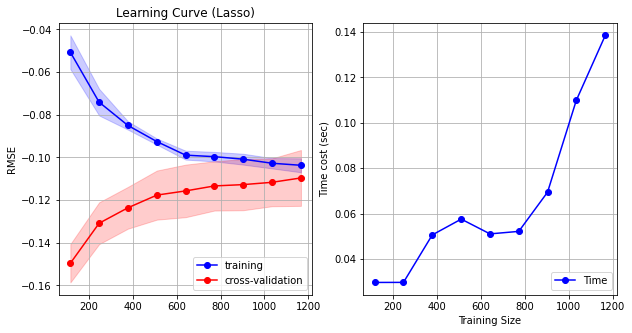

In [11]:
examine_learning_curve(model_lasso, Xtrain, ytrain, modelname="Lasso")

In [56]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

model_ridge = Ridge(alpha=10.0)
model_lasso = Lasso(alpha=0.00052, max_iter=1.e5)
model_rf = RandomForestRegressor(n_estimators=400, max_features='sqrt', max_depth=100, min_samples_split=2, min_samples_leaf=1) # Random Forest Decision Tree
model_svr = SVR(C=20, epsilon=0.008, gamma=0.0003)
model_lgbm = LGBMRegressor(verbose=0, objective='regression', num_leaves=6, max_depth=8, learning_rate=0.1, n_estimators=300, min_data_in_leaf=32, min_child_weight=0.4, random_state=42)
model_xgb = XGBRegressor(n_estimators=800, min_child_weight=3, max_depth=3, gamma=0, learning_rate=0.08, subsample=0.7, reg_lambda=0.1, reg_alpha=0.0, colsample_bytree=1.0) # Extreme Gradient Boosting Decision Tree
model_stack = StackingRegressor(estimators=[('ridge', model_ridge), \
                                            ('lasso', model_lasso),\
                                            ('svr', model_svr),\
                                            #('lgbm', model_lgbm),\
                                            ('rf', model_rf),\
                                            ('xgb', model_xgb)],\
                                cv = kfolds)

## Evaluate Model

Now evaluate the cross validation scores of these models. The linear models perform pretty well. 

**Stacking multiple regressors results in a significant improvement in the cross-validation score.**


Note: This can be **very slow**, especially for the stacked regressor

In [67]:
def cv_rmse(model, X, y, modelname=""):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=8))
    print ("%-15s: %f %f" % (modelname, rmse.mean(), rmse.std()))

In [68]:
cv_rmse(model_lasso, Xtrain, ytrain, "Lasso")
cv_rmse(model_ridge, Xtrain, ytrain, "Ridge")
cv_rmse(model_svr, Xtrain, ytrain, "SVR")
cv_rmse(model_rf, Xtrain, ytrain, "Random Forest")
cv_rmse(model_xgb, Xtrain, ytrain, "XGBoost")
#cv_rmse(model_lgbm, Xtrain, ytrain, "Light GBM")

Lasso          : 0.109253 0.012873
Ridge          : 0.109640 0.012433
SVR            : 0.108060 0.015160
Random Forest  : 0.136779 0.014748
XGBoost        : 0.117446 0.012945


In [184]:
# Slow, so use a different cell here
cv_rmse(model_stack, Xtrain, ytrain, "Stack")

Stack          : 0.105722 0.013156


## Fit the Models

In [109]:
model_xgb.fit(Xtrain, ytrain)
model_lasso.fit(Xtrain, ytrain)
model_ridge.fit(Xtrain, ytrain)
model_rf.fit(Xtrain, ytrain)
model_svr.fit(Xtrain, ytrain)
#model_lgbm.fit(Xtrain, ytrain)
model_stack.fit(Xtrain, ytrain)

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('ridge', Ridge(alpha=10.0)),
                              ('lasso',
                               Lasso(alpha=0.00052, max_iter=100000.0)),
                              ('svr', SVR(C=20, epsilon=0.008, gamma=0.0003)),
                              ('rf',
                               RandomForestRegressor(max_depth=100,
                                                     max_features='sqrt',
                                                     n_estimators=400)),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_byle...
                                            colsample_bytree=1.0, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                    

## Learning Curves

The tree based models overfit the data while the linear models perform well.

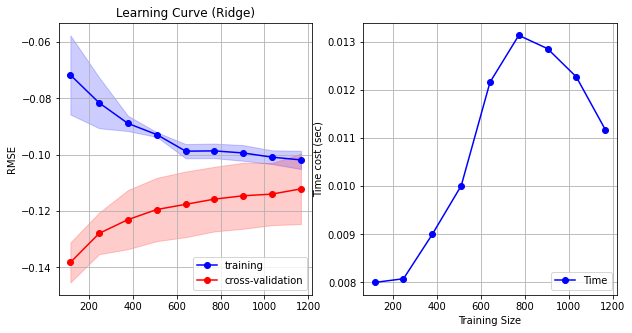

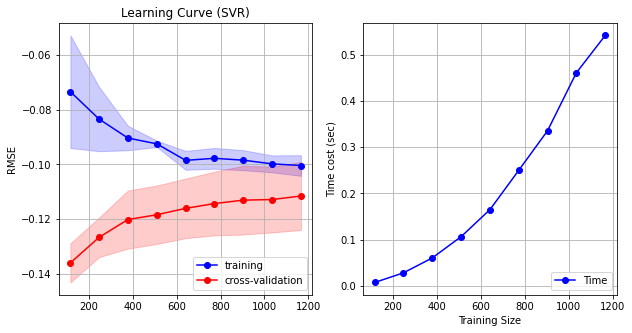

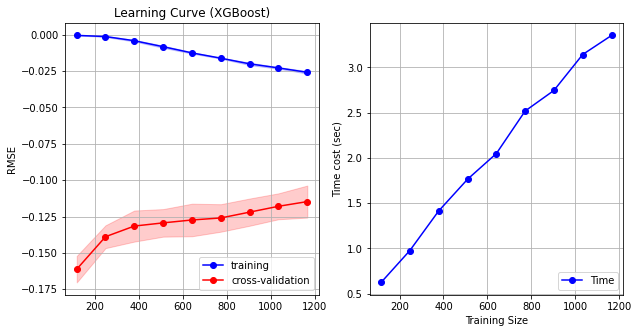

In [128]:
examine_learning_curve(model_ridge, Xtrain, ytrain, modelname="Ridge")
examine_learning_curve(model_svr, Xtrain, ytrain, modelname="SVR")
examine_learning_curve(model_xgb, Xtrain, ytrain, modelname="XGBoost")

## Prediction

In [187]:
def predict():
    test = pd.read_csv("./data/test.csv")
    testId = test['Id']
    Xtest = test.copy()
    Xtest, _ = preprocessing(Xtest, rank_mapping)
    
    Xtest = ct.transform(Xtest)
    pred_ridge = np.exp(model_ridge.predict(Xtest)) - 1.0
    pred_lasso = np.exp(model_lasso.predict(Xtest)) - 1.0
    pred_xgb = np.exp(model_xgb.predict(Xtest)) - 1.0
    pred_stack = np.exp(model_stack.predict(Xtest)) - 1.0
    pred_svr = np.exp(model_svr.predict(Xtest)) - 1.0
    pred_rf = np.exp(model_rf.predict(Xtest)) - 1.0
    #pred_lgbm = np.exp(model_lgbm.predict(Xtest)) - 1.0                

    pred = 0.55 * pred_stack + \
        0.1 * pred_ridge + \
        0.1 * pred_lasso + \
        0.1 * pred_xgb + \
        0.1 * pred_svr + \
        0.05 * pred_rf

    out = pd.DataFrame({'Id':testId, 'SalePrice':pred})
    
    out.to_csv("./output/submission.csv", index=False)
    return out


In [177]:
out = predict()
print(out)
# outcomp = pd.read_csv("./output/submission_best_12.388.csv")
# fig = plt.figure(figsize=(6,6))
# plt.plot(out['SalePrice'], outcomp['SalePrice'], "b.")
# ax = plt.gca()
# ax.set_xlim(0., 1.e6)
# ax.set_ylim(0., 1.e6)
# ax.plot([0., 1.e6], [0.0, 1.e6], "k--")

Skewness of variables: 
----------------
LotArea                  3.112013
Condition2               -2.786181
RoofMatl                 14.694945
MasVnrArea               2.546947
ExterCond                1.245217
BsmtQual                 -2.005638
BsmtCond                 -4.175228
BsmtFinSF1               1.165130
BsmtFinType2             2.453043
BsmtFinSF2               4.038796
CentralAir               -3.394101
1stFlrSF                 1.556592
LowQualFinSF             16.150628
GrLivArea                1.129240
BsmtHalfBath             3.779085
KitchenAbvGr             4.074860
GarageQual               -3.553782
GarageCond               -3.634625
PavedDrive               2.712652
WoodDeckSF               2.128569
OpenPorchSF              2.685015
EnclosedPorch            4.664371
3SsnPorch                12.511336
ScreenPorch              3.784349
PoolArea                 20.176117
MiscVal                  20.054543
        Id      SalePrice
0     1461  121350.232903
1     1462  

## A Bad Outlier

There's this one outlier in the **test** data: Id = 2550

It gets an OverallQual of 10 and a huge size so most of the time my model predicts a very high price.
However, when I made multiple submissions with different values for this outlier (while keeping the rest the same) the leaderboard score changed drastically:

| SalePrice | Leaderboard Score |
|-----------|-------------------|
|948458     |0.12388            |
|800000     |0.12241            |
|600000     |0.12025            |
|300000     |0.11690            |
|100000     |0.11729            |

It appears that this house should have a pretty low price ~200000, in spite of its quality and size measures, if my understanding on how leaderboard scores are calculated is correct.

However, it should be noted that I removed two outliers from the training set that are quite similar to this outlier in the test set. If I included those two outliers, the score will likely be less affected by this outlier although it might lower the model accuracy in general.

Some findings related to this:

- I found that tree-based models tend to predict lower values than linear models for this outlier. This makes it hard to really say which models are better for this dataset solely from the leaderboard score. Cross-validation scores from the training set might be a better choice for evaluating models.
- Some models use leaky information from the test set in data engineering. This likely will improve the leaderboard score because of the outliers.
- Many top submissions used arbitrary coefficients for blending models but it is unclear whether or not most improvements from blending came from a better prediction of this outlier.
- I spent quite some time trying to figure out this anomaly. I think it might be a good habit to always check if the train and test sets come from a same distribution.

Here are scatter plots showing the training data (blue), test data (black) and the outlier (red) with y fixed to 200000.

        Id      SalePrice
1089  2550  798352.449896


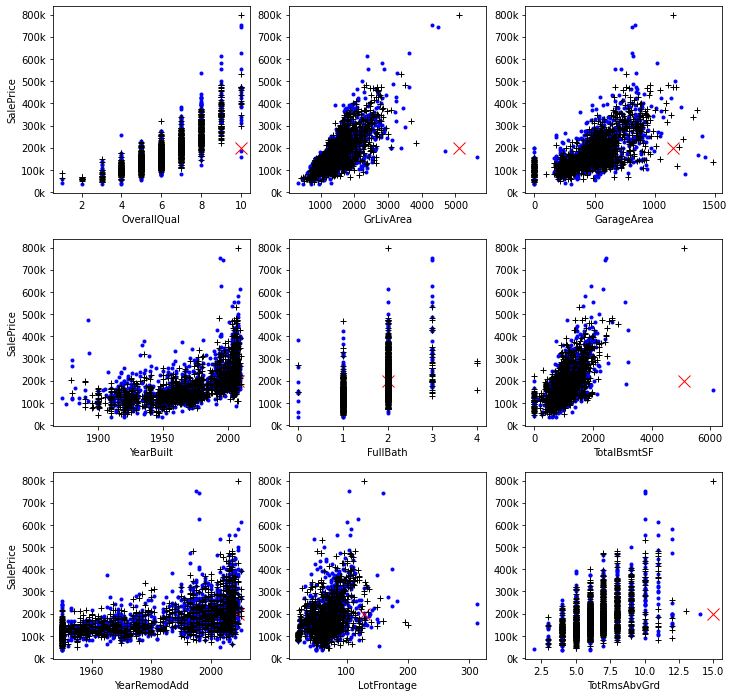

In [188]:
import matplotlib as mpl
print(out[out['SalePrice']> 600000])
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
#print(test.columns)
bad = test[test['Id'] == 2550]
train.corrwith(train['SalePrice'], method='spearman').sort_values(ascending=False)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
features = ['OverallQual', 'GrLivArea', 'GarageArea', \
            'YearBuilt', 'FullBath', 'TotalBsmtSF', \
            'YearRemodAdd', 'LotFrontage', 'TotRmsAbvGrd']
axs = axs.flatten()
y = train['SalePrice']
for i, var in enumerate(features):
    axs[i].plot(train[var], y, "b.")
    axs[i].plot(bad[var], 200000., "rx", markersize=12)
    axs[i].plot(test[var], out['SalePrice'], "k+")
    axs[i].set_xlabel(var)
    ax = axs[i]
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
    ylabels = ['{:,.0f}'.format(y/1000) + 'k' for y in ticks_loc]
    ax.set_yticklabels(ylabels)
    if(i % 3 == 0): ax.set_ylabel("SalePrice")
    
plt.subplots_adjust(hspace=0.25)